# Performance evaluation of Terapixel rendering in Cloud (Super)computing

In [ ]:
# !pip install sweetviz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import sweetviz as sv
import IPython
from dateutil import parser
from datetime import datetime as dt, timedelta, date

In [4]:
app_check = pd.read_csv("../data/application-checkpoints.csv")
gpu = pd.read_csv("../data/gpu.csv")
task_xy = pd.read_csv("../data/task-x-y.csv")
app_conf_df = pd.read_csv("../data/processed_app_conf.csv")
event_total_duration_df = pd.read_csv("../data/event-total-duration.csv")

In [ ]:
app_check.head()

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
1,2018-11-08T07:42:29.842Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
2,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
3,2018-11-08T07:42:29.845Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d
4,2018-11-08T07:43:13.957Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,20fb9fcf-a927-4a4b-a64c-70258b66b42d


In [ ]:
app_check.shape

(660400, 6)

In [ ]:
gpu.head()

,timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc
0,2018-11-08T08:27:10.314Z,8b6a0eebc87b4cb2b0539e81075191b900001C,323217055910,GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534,131.55,48,92,53
1,2018-11-08T08:27:10.192Z,d8241877cd994572b46c861e5d144c85000000,323617020295,GPU-04a2dea7-f4f1-12d0-b94d-996446746e6f,117.03,40,92,48
2,2018-11-08T08:27:10.842Z,db871cd77a544e13bc791a64a0c8ed50000006,323217056562,GPU-f4597939-a0b4-e78a-2436-12dbab9a350f,121.64,45,91,44
3,2018-11-08T08:27:10.424Z,b9a1fa7ae2f74eb68f25f607980f97d7000010,325217085931,GPU-ad773c69-c386-a4be-b214-1ea4fc6045df,50.23,38,90,43
4,2018-11-08T08:27:10.937Z,db871cd77a544e13bc791a64a0c8ed50000003,323217056464,GPU-2d4eed64-4ca8-f12c-24bc-28f036493ea2,141.82,41,90,47


In [ ]:
gpu.shape

(1543681, 8)

In [ ]:
task_xy.head()

,taskId,jobId,x,y,level
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12
1,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12
3,000993b6-fc88-489d-a4ca-0a44fd800bd3,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,235,11,12
4,000b158b-0ba3-4dca-bf5b-1b3bd5c28207,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,171,53,12


In [ ]:
task_xy.shape

(65793, 5)

In [ ]:
# gpu_report = sv.analyze(gpu, target_feat = "powerDrawWatt")
# gpu_report.show_html(filepath = "/content/drive/MyDrive/terascope/reports/gpu_report.html")

In [ ]:
# IPython.display.HTML(filename = "/content/drive/MyDrive/terascope/reports/gpu_report.html")

In [ ]:
app_check.value_counts("eventName")

eventName
Uploading        132080
TotalRender      132080
Tiling           132080
Saving Config    132080
Render           132080
dtype: int64

In [ ]:
app_check[app_check["eventName"] == "Tiling"].head()

,timestamp,hostname,eventName,eventType,jobId,taskId
0,2018-11-08T07:41:55.921Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,b47f0263-ba1c-48a7-8d29-4bf021b72043
7,2018-11-08T07:43:57.223Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,3dd4840c-47f2-4dcc-a775-df2ef6498d71
12,2018-11-08T07:46:05.517Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c5a7a2df-ddeb-4f54-9cc5-446e3a9ba1ba
16,2018-11-08T07:47:38.464Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c8c93ada-22ea-4ca8-aa1b-9f9d4b89bfba
17,2018-11-08T07:49:41.858Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,bce8d6bb-8cfe-475b-ae03-af28d1fac10a


Text(0.5, 1.0, 'Power Draw vs Temperature of the GPU')

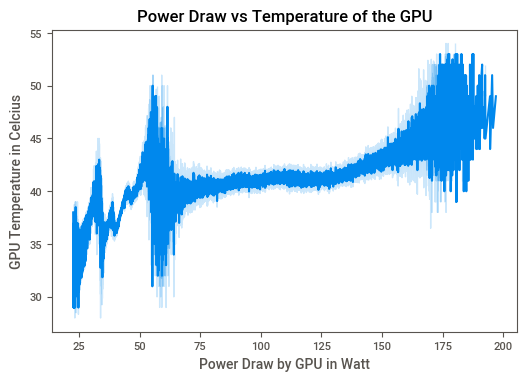

In [ ]:
ax = sns.lineplot(data=gpu, x="powerDrawWatt", y="gpuTempC")
plt.xlabel('Power Draw by GPU in Watt')
plt.ylabel('GPU Temperature in Celcius')
plt.title("Power Draw vs Temperature of the GPU")
plt.show()

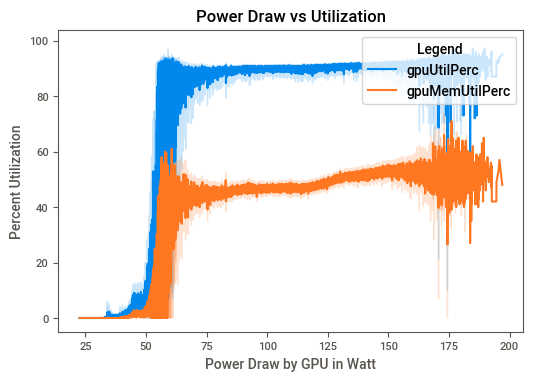

In [ ]:
ax = sns.lineplot(data=pd.melt(gpu[["powerDrawWatt", "gpuUtilPerc", "gpuMemUtilPerc"]], 'powerDrawWatt'), x="powerDrawWatt", y="value", hue = "variable")
plt.xlabel('Power Draw by GPU in Watt')
plt.ylabel('Percent Utilization')
plt.title("Power Draw vs Utilization")
plt.legend(loc='upper right', title='Legend')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 99.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 99.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 99.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 99.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 98.9% of the points cannot be placed; y

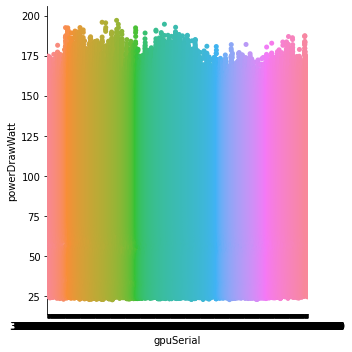

In [ ]:
sns.catplot(x="gpuSerial", y="powerDrawWatt", kind="swarm", data=gpu)

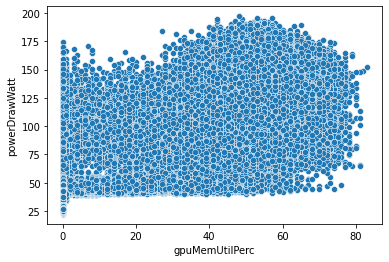

In [ ]:
sns.scatterplot(data=gpu, x="gpuMemUtilPerc", y="powerDrawWatt")
plt.show()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=0)
labs = kmeans.fit_predict(gpu[['powerDrawWatt', 'gpuTempC']])  

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


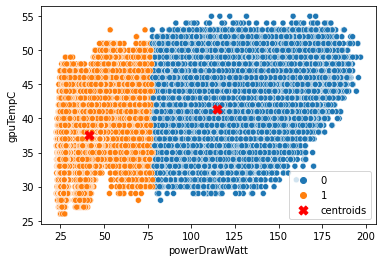

In [ ]:
sns.scatterplot(data=gpu, x="powerDrawWatt", y="gpuTempC", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()

In [ ]:
app_check[app_check['taskId'] == "c9e249d8-52ed-40c6-8713-b5cbf02ea87e"]

,timestamp,hostname,eventName,eventType,jobId,taskId
8,2018-11-08T07:44:47.555Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
9,2018-11-08T07:45:20.713Z,0d56a730076643d585f77e00d2d8521a00000N,Render,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
10,2018-11-08T07:45:21.898Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
226429,2018-11-08T07:45:21.898Z,0d56a730076643d585f77e00d2d8521a00000N,Uploading,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
395554,2018-11-08T07:44:47.555Z,0d56a730076643d585f77e00d2d8521a00000N,TotalRender,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
395555,2018-11-08T07:45:20.720Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
395556,2018-11-08T07:45:21.697Z,0d56a730076643d585f77e00d2d8521a00000N,Tiling,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
618469,2018-11-08T07:44:47.557Z,0d56a730076643d585f77e00d2d8521a00000N,Saving Config,STOP,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
618470,2018-11-08T07:44:47.557Z,0d56a730076643d585f77e00d2d8521a00000N,Render,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e
618471,2018-11-08T07:45:20.714Z,0d56a730076643d585f77e00d2d8521a00000N,Uploading,START,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,c9e249d8-52ed-40c6-8713-b5cbf02ea87e


In [ ]:
from datetime import datetime as dt, timedelta, date
app_check["time"] = app_check["timestamp"].apply(lambda x: dt.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z'))
# df[cols] = df[cols].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f%z'))

In [ ]:
app_check['time'] = [dt.time(d) for d in app_check['time']] 

In [ ]:
df = app_check[['eventName', 'eventType', 'taskId', 'time']]

In [ ]:
df.head()

,eventName,eventType,taskId,time
0,Tiling,STOP,b47f0263-ba1c-48a7-8d29-4bf021b72043,07:41:55.921000
1,Saving Config,START,20fb9fcf-a927-4a4b-a64c-70258b66b42d,07:42:29.842000
2,Saving Config,STOP,20fb9fcf-a927-4a4b-a64c-70258b66b42d,07:42:29.845000
3,Render,START,20fb9fcf-a927-4a4b-a64c-70258b66b42d,07:42:29.845000
4,TotalRender,STOP,20fb9fcf-a927-4a4b-a64c-70258b66b42d,07:43:13.957000


In [ ]:
df.shape

(660400, 4)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(657930, 4)

In [ ]:
df.head()

,eventName,eventType,taskId,time
0,Tiling,STOP,b47f0263-ba1c-48a7-8d29-4bf021b72043,07:41:55.921000
1,Saving Config,START,20fb9fcf-a927-4a4b-a64c-70258b66b42d,07:42:29.842000
2,Saving Config,STOP,20fb9fcf-a927-4a4b-a64c-70258b66b42d,07:42:29.845000
3,Render,START,20fb9fcf-a927-4a4b-a64c-70258b66b42d,07:42:29.845000
4,TotalRender,STOP,20fb9fcf-a927-4a4b-a64c-70258b66b42d,07:43:13.957000


In [8]:
event_total_duration_df

,Unnamed: 0,eventName,totalDuration
0,0,Tiling,761.96
1,1,Saving Config,0.05
2,2,Render,17.99
3,3,TotalRender,787.77
4,4,Uploading,25.75


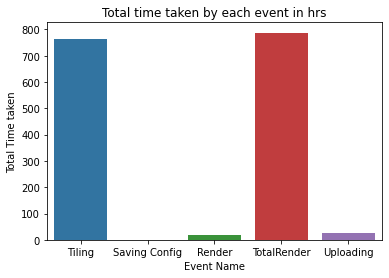

In [6]:
ax = sns.barplot(data=event_total_duration_df, x="eventName", y="totalDuration")
plt.xlabel('Event Name')
plt.ylabel('Total Time taken')
plt.title("Total time taken by each event in hrs")
plt.show()

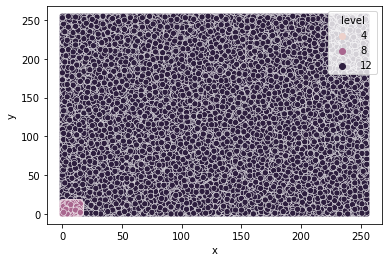

In [16]:
sns.scatterplot(data=task_xy, x="x", y="y", hue = 'level')
plt.rcParams["figure.figsize"] = (16,9)
plt.show()

Unnamed: 0                                                700
hostname               a77ef58b13ad4c01b769dac8409af3f800000A
eventName                                              Render
jobId         1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705
taskId                   21445d29-0bdc-4d9b-b78d-0ed88ed18e0a
START                                         07:43:58.737000
STOP                                          07:44:59.316000
duration                                                 0.02
Name: 700, dtype: object

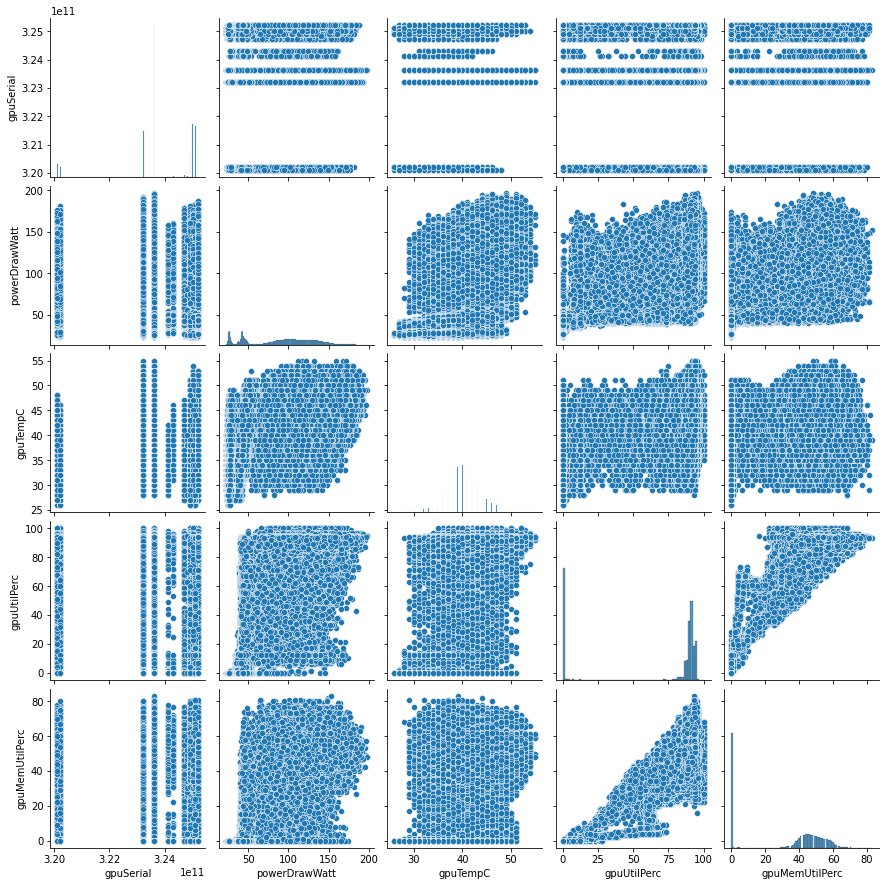

In [31]:
sns.pairplot(gpu, )